# Proximal Policy Optimization Algorithms

## Environment I have tested for 

1) Acrobot - 'Acrobot-v1'
2) Lunar Lander - 'LunerLander-v3'
3) HalfCheetah - 'HalfCheetah-v5'
4) Ant - 'Ant-v5'
5) InvertedDoublePendulum


In [1]:
import gymnasium as gym
import torch 
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

In [2]:
class HyperParams:
    gamma = 0.99
    lamda = 0.98
    hidden = 64
    critic_lr = 0.0003
    actor_lr = 0.0003
    batch_size = 64
    l2_rate = 0.001
    max_kl = 0.01
    clip_param = 0.2

hp = HyperParams()

class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, isDiscrete=False):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hp.hidden)
        self.fc2 = nn.Linear(hp.hidden, hp.hidden)
        self.fc3 = nn.Linear(hp.hidden, num_outputs)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)
        self.isDiscrete = isDiscrete

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        mu = self.fc3(x)
        if self.isDiscrete:
            return mu, None, None
        else:
            logstd = torch.zeros_like(mu)
            std = torch.exp(logstd)
            return mu, std, logstd


class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hp.hidden)
        self.fc2 = nn.Linear(hp.hidden, hp.hidden)
        self.fc3 = nn.Linear(hp.hidden, 1)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        v = self.fc3(x)
        return v


In [3]:
class PPO:
    def __init__(self, env_name):
        self.env = env_name
        self.num_states = None
        self.num_action = None
        self.isDiscrete = isinstance(gym.make(env_name).action_space, gym.spaces.Discrete)

    def get_gae(self,rewards, masks, values):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)
        advants = torch.zeros_like(rewards)

        running_returns = 0
        previous_value = 0
        running_advants = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + hp.gamma * running_returns * masks[t]
            running_tderror = rewards[t] + hp.gamma * previous_value * masks[t] - \
                        values.data[t]
            running_advants = running_tderror + hp.gamma * hp.lamda * \
                            running_advants * masks[t]

            returns[t] = running_returns
            previous_value = values.data[t]
            advants[t] = running_advants

        advants = (advants - advants.mean()) / advants.std()
        return returns, advants


    def surrogate_loss(self,actor, advants, states, old_policy, actions, index):
        if self.isDiscrete:
            logits = actor(torch.Tensor(states))[0]
            dist = torch.distributions.Categorical(logits=logits)
            new_policy = dist.log_prob(actions.squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(torch.Tensor(states))
            new_policy = self.log_density(actions, mu, std, logstd)

        old_policy = old_policy[index]

        ratio = torch.exp(new_policy - old_policy)
        surrogate = ratio * advants
        return surrogate, ratio

    def log_density(self,x, mu, std, logstd):
        var = std.pow(2)
        log_density = - (x - mu).pow(2) / (2 * var) - 0.5 * np.log(2 * np.pi) - logstd
        return log_density.sum(1, keepdim=True)

    def get_returns(self,rewards, masks):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)

        running_returns = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + hp.gamma * running_returns * masks[t]
            returns[t] = running_returns

        returns = (returns - returns.mean()) / returns.std()
        return returns


    def get_loss(self, actor, returns, states, actions):
        states = torch.Tensor(states)
        actions = torch.Tensor(actions)
        returns = returns.unsqueeze(1)
        
        if self.isDiscrete:
            logits = actor(states)[0]
            dist = torch.distributions.Categorical(logits=logits)
            log_policy = dist.log_prob(actions.squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(states)
            print(mu, std, logstd)
            log_policy = self.log_density(actions, mu, std, logstd)
        
        objective = (returns * log_policy).mean()
        return -objective



    def train_critic(self,critic, states, returns, critic_optim):
        criterion = torch.nn.MSELoss()
        n = len(states)
        arr = np.arange(n)

        for epoch in range(5):
            np.random.shuffle(arr)

            for i in range(n // hp.batch_size):
                batch_index = arr[hp.batch_size * i: hp.batch_size * (i + 1)]
                batch_index = torch.LongTensor(batch_index)
                inputs = torch.Tensor(states)[batch_index]
                target = returns.unsqueeze(1)[batch_index]

                values = critic(inputs)
                loss = criterion(values, target)
                critic_optim.zero_grad()
                loss.backward()
                critic_optim.step()


    def train_actor(self,actor, returns, states, actions, actor_optim):
        loss = self.get_loss(actor, returns, states, actions)
        actor_optim.zero_grad()
        loss.backward()
        actor_optim.step()


    def train_model(self,actor, critic, memory, actor_optim, critic_optim):
        states = np.vstack([m[0] for m in memory])
        actions = np.vstack([m[1] for m in memory])
        rewards = [m[2] for m in memory]
        masks = [m[3] for m in memory]
        values = critic(torch.Tensor(states))
 
        # step 1: get returns and GAEs and log probability of old policy
        returns, advants = self.get_gae(rewards, masks, values)
        if self.isDiscrete:
            logits = actor(torch.Tensor(states))[0]
            dist = torch.distributions.Categorical(logits=logits)
            old_policy = dist.log_prob(torch.Tensor(actions).squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(torch.Tensor(states))
            old_policy = self.log_density(torch.Tensor(actions), mu, std, logstd)

        old_values = critic(torch.Tensor(states))

        criterion = torch.nn.MSELoss()
        n = len(states)
        arr = np.arange(n)
 
        # step 2: get value loss and actor loss and update actor & critic
        for epoch in range(10):
            np.random.shuffle(arr)

            for i in range(n // hp.batch_size):
                batch_index = arr[hp.batch_size * i: hp.batch_size * (i + 1)]
                batch_index = torch.LongTensor(batch_index)
                inputs = torch.Tensor(states)[batch_index]
                returns_samples = returns.unsqueeze(1)[batch_index]
                advants_samples = advants.unsqueeze(1)[batch_index]
                actions_samples = torch.Tensor(actions)[batch_index]
                oldvalue_samples = old_values[batch_index].detach()

               
                critic_optim.zero_grad()
                values = critic(inputs)
                clipped_values = oldvalue_samples + \
                                torch.clamp(values - oldvalue_samples,
                                            -hp.clip_param,
                                            hp.clip_param)
                critic_loss1 = criterion(clipped_values, returns_samples)
                critic_loss2 = criterion(values, returns_samples)
                critic_loss = torch.max(critic_loss1, critic_loss2).mean()
                critic_loss.backward()
                critic_optim.step()

                actor_optim.zero_grad()
                loss, ratio = self.surrogate_loss(actor, advants_samples, inputs,
                                        old_policy.detach(), actions_samples,
                                        batch_index)

                clipped_ratio = torch.clamp(ratio,
                                            1.0 - hp.clip_param,
                                            1.0 + hp.clip_param)
                clipped_loss = clipped_ratio * advants_samples
                actor_loss = -torch.min(loss, clipped_loss).mean()

                actor_loss.backward()
                actor_optim.step()

    def make_env(self):
        env = gym.make(self.env)
        return env
    

    def get_action(self, actor, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        if self.isDiscrete:
            logits = actor(state_tensor)[0]
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample().item() 
        else:
            mu, std, _ = actor(state_tensor)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample().squeeze(0).detach().numpy()
            action = np.clip(action, -1, 1) 
        return action

    
    def main(self):
        env = self.make_env()

        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n if self.isDiscrete else env.action_space.shape[0]

        print("State space: ", self.num_states)
        print("Action space: ", self.num_actions)

        actor = Actor(self.num_states, self.num_actions, self.isDiscrete)
        critic = Critic(self.num_states)

        actor_optim = optim.Adam(actor.parameters(), lr=hp.actor_lr)
        critic_optim = optim.Adam(critic.parameters(), lr=hp.critic_lr, weight_decay=hp.l2_rate)

        writer = SummaryWriter(log_dir=f"runs/{self.env}_PPO")

        episodes = 0
        scores_over_time = []
        for iter in range(50):
            actor.eval(), critic.eval()
            memory = deque()

            steps = 0
            scores = []
            while steps < 10000:
                episodes += 1
                state = env.reset(seed=42)[0] 
                score = 0
                for _ in range(10000):

                    steps += 1 
                    
                    action = self.get_action(actor, state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    if done:
                        mask = 0
                    else:
                        mask = 1

                    memory.append([state, action, reward, mask])

                    score += reward
                    state = next_state

                    if done:
                        break
                scores.append(score)
            score_avg = np.mean(scores)
            scores_over_time.append(score_avg)
            print('{} episode score is {:.2f}'.format(episodes, score_avg))
            writer.add_scalar('log/score', float(score_avg), iter)

            actor.train(), critic.train()
            torch.save(actor.state_dict(), f'actor_{self.env}_PPO.pth')
            torch.save(critic.state_dict(), f'critic_{self.env}_PPO.pth')
            self.train_model(actor, critic, memory, actor_optim, critic_optim)

        np.save(f"scores_{self.env}_PPO.npy", np.array(scores_over_time))


In [4]:
ppo = PPO('HalfCheetah-v5')
ppo.main()

State space:  17
Action space:  6
10 episode score is -312.95
20 episode score is -328.66
30 episode score is -320.16
40 episode score is -350.80
50 episode score is -357.63
60 episode score is -327.66
70 episode score is -307.59
80 episode score is -329.40
90 episode score is -330.15
100 episode score is -281.22
110 episode score is -294.22
120 episode score is -279.79
130 episode score is -313.12
140 episode score is -288.56
150 episode score is -297.65
160 episode score is -276.52
170 episode score is -297.60
180 episode score is -303.64
190 episode score is -261.19
200 episode score is -262.35
210 episode score is -262.81
220 episode score is -265.99
230 episode score is -308.63
240 episode score is -277.97
250 episode score is -280.43
260 episode score is -272.74
270 episode score is -270.38
280 episode score is -231.07
290 episode score is -248.68
300 episode score is -245.31
310 episode score is -238.36
320 episode score is -230.02
330 episode score is -222.20
340 episode score 

6
HalfCheetah-v5


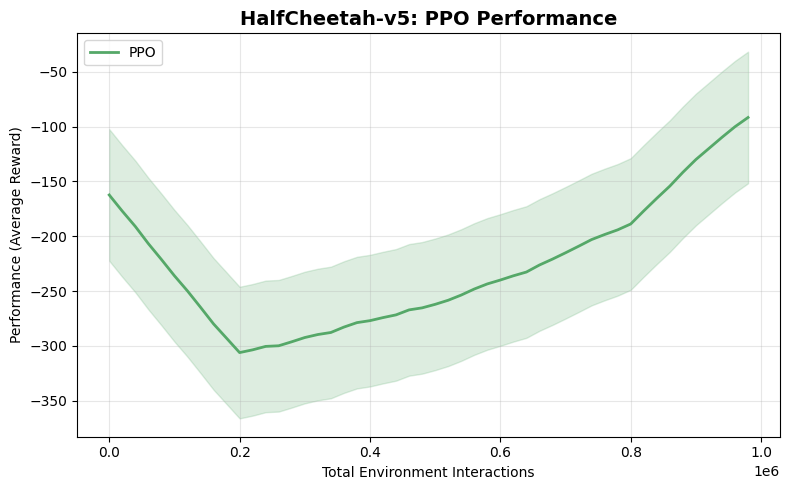

In [5]:
print(ppo.num_actions)
print(ppo.env)

actor = Actor(ppo.num_states, ppo.num_actions, ppo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{ppo.env}_PG.pth"))

env = ppo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{ppo.env}_PPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{ppo.env}: PPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [6]:
ppo = PPO('Acrobot-v1') 
ppo.main()

State space:  6
Action space:  3
20 episode score is -500.00
40 episode score is -500.00
60 episode score is -500.00
80 episode score is -500.00
100 episode score is -500.00
120 episode score is -500.00
140 episode score is -500.00
160 episode score is -500.00
180 episode score is -500.00
200 episode score is -500.00
220 episode score is -500.00
240 episode score is -500.00
260 episode score is -500.00
280 episode score is -500.00
300 episode score is -500.00
321 episode score is -480.90
344 episode score is -439.96
368 episode score is -429.54
395 episode score is -379.85
424 episode score is -344.41
458 episode score is -294.53
494 episode score is -279.39
532 episode score is -262.63
572 episode score is -251.25
610 episode score is -264.87
651 episode score is -243.85
697 episode score is -221.83
742 episode score is -224.62
791 episode score is -203.35
839 episode score is -209.71
891 episode score is -194.79
942 episode score is -199.31
987 episode score is -223.64
1036 episode s

3
Acrobot-v1


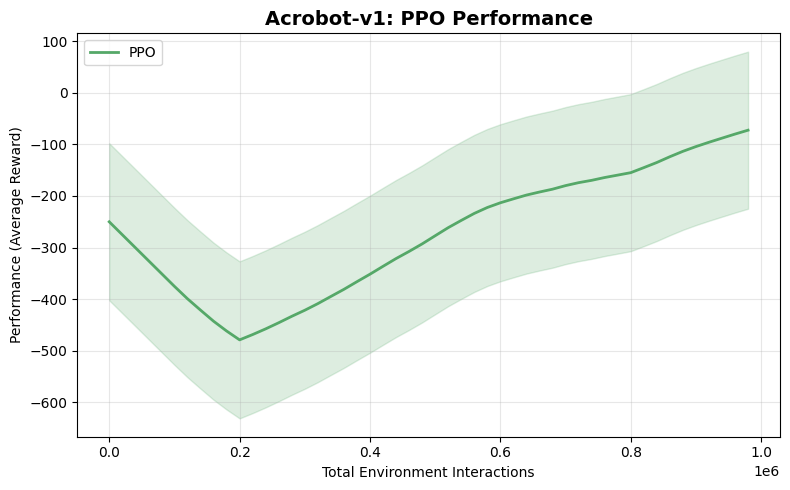

In [7]:
print(ppo.num_actions)
print(ppo.env)

actor = Actor(ppo.num_states, ppo.num_actions, ppo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{ppo.env}_PG.pth"))

env = ppo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{ppo.env}_PPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{ppo.env}: PPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
ppo = PPO('LunarLander-v3')
ppo.main()

/Users/trijalsrivastava/Code/CS778/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


State space:  8
Action space:  4
88 episode score is -235.38
174 episode score is -190.95
252 episode score is -171.33
323 episode score is -128.24
390 episode score is -92.08
447 episode score is -91.28
505 episode score is -70.59
561 episode score is -42.19
601 episode score is -35.55
626 episode score is 4.17
650 episode score is -1.99
668 episode score is 10.93
680 episode score is 71.68
695 episode score is 59.42
709 episode score is 53.26
722 episode score is 65.70
736 episode score is 43.23
748 episode score is 68.63
760 episode score is 52.58
772 episode score is 57.30
783 episode score is 49.50
794 episode score is 103.18
805 episode score is 132.84
816 episode score is 123.93
828 episode score is 136.61
842 episode score is 178.58
856 episode score is 171.42
872 episode score is 154.62
886 episode score is 137.02
900 episode score is 177.92
913 episode score is 110.70
926 episode score is 124.05
941 episode score is 177.16
957 episode score is 179.97
973 episode score is 181.

4
LunarLander-v3


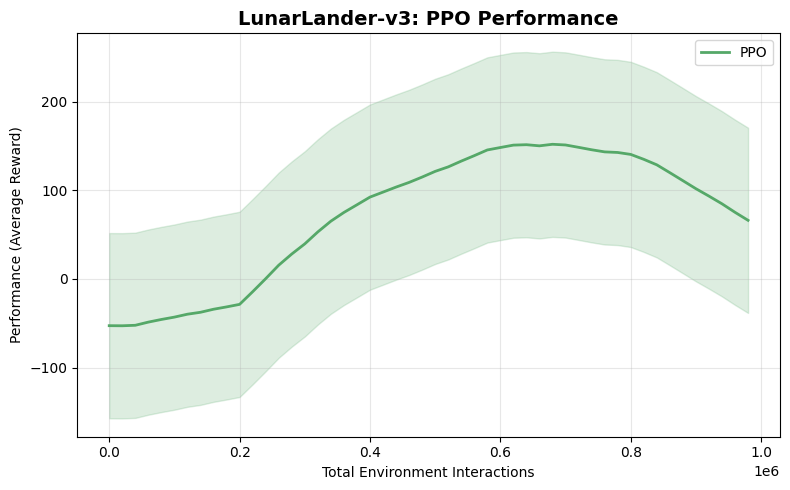

In [9]:
print(ppo.num_actions)
print(ppo.env)

actor = Actor(ppo.num_states, ppo.num_actions, ppo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{ppo.env}_PG.pth"))

env = ppo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{ppo.env}_PPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{ppo.env}: PPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
ppo = PPO('Ant-v5')
ppo.main()

State space:  105
Action space:  8
58 episode score is -191.28
141 episode score is -135.38
224 episode score is -141.02
356 episode score is -91.58
459 episode score is -120.98
598 episode score is -83.55
669 episode score is -182.98
751 episode score is -154.32
824 episode score is -181.70
939 episode score is -124.83
1057 episode score is -108.65
1147 episode score is -149.21
1209 episode score is -221.15
1293 episode score is -165.98
1344 episode score is -284.94
1417 episode score is -201.39
1488 episode score is -199.05
1588 episode score is -136.45
1734 episode score is -91.73
1844 episode score is -134.60
1926 episode score is -178.72
2006 episode score is -184.46
2115 episode score is -134.95
2208 episode score is -161.57
2299 episode score is -154.34
2393 episode score is -153.43
2489 episode score is -162.94
2573 episode score is -188.63
2668 episode score is -154.43
2763 episode score is -152.94
2879 episode score is -133.72
2978 episode score is -147.56
3086 episode score 

8
Ant-v5


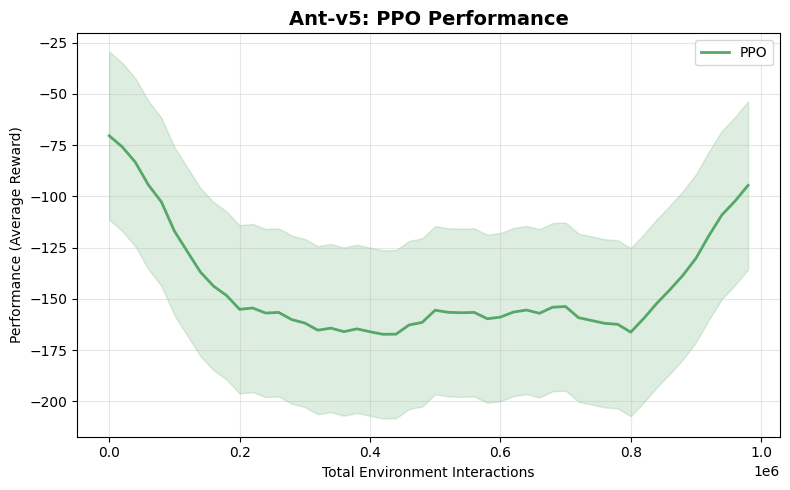

In [11]:
print(ppo.num_actions)
print(ppo.env)

actor = Actor(ppo.num_states, ppo.num_actions, ppo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{ppo.env}_PG.pth"))

env = ppo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{ppo.env}_PPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{ppo.env}: PPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
ppo = PPO('Reacher-v5')
ppo.main()

State space:  10
Action space:  2
200 episode score is -60.43
400 episode score is -60.37
600 episode score is -61.17
800 episode score is -61.28
1000 episode score is -64.04
1200 episode score is -64.32
1400 episode score is -64.70
1600 episode score is -65.39
1800 episode score is -65.67
2000 episode score is -64.65
2200 episode score is -65.91
2400 episode score is -65.57
2600 episode score is -65.90
2800 episode score is -65.53
3000 episode score is -65.83
3200 episode score is -66.55
3400 episode score is -67.08
3600 episode score is -67.42
3800 episode score is -68.16
4000 episode score is -67.66
4200 episode score is -68.69
4400 episode score is -68.77
4600 episode score is -68.75
4800 episode score is -69.62
5000 episode score is -68.83
5200 episode score is -69.18
5400 episode score is -69.14
5600 episode score is -69.54
5800 episode score is -69.84
6000 episode score is -68.97
6200 episode score is -69.16
6400 episode score is -69.72
6600 episode score is -69.42
6800 episode 

2
Reacher-v5


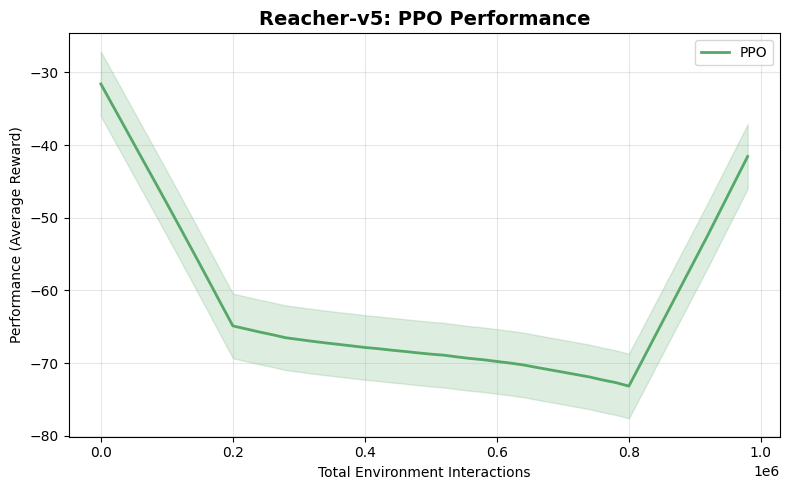

In [13]:

print(ppo.num_actions)
print(ppo.env)

actor = Actor(ppo.num_states, ppo.num_actions, ppo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{ppo.env}_PG.pth"))

env = ppo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{ppo.env}_PPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{ppo.env}: PPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Total episode reward: -82.99872103286033


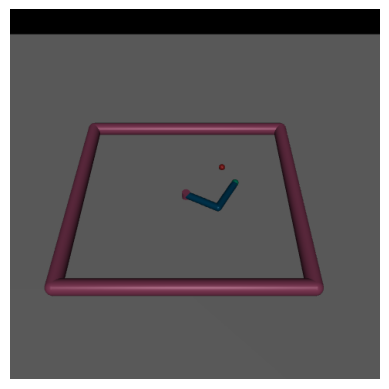

In [14]:
frames = []  # for inline animation
while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    if actor.isDiscrete:
        logits, _, _ = actor(state_tensor)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample().item()
    else:
        mu, std, _ = actor(state_tensor)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample().squeeze(0).detach().numpy()
        action = np.clip(action, env.action_space.low, env.action_space.high)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

    frame = env.render()  
    frames.append(frame)

    state = next_state

for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.03)


print("Total episode reward:", total_reward)
env.close()

📈 Plotting Acrobot-v1 ...


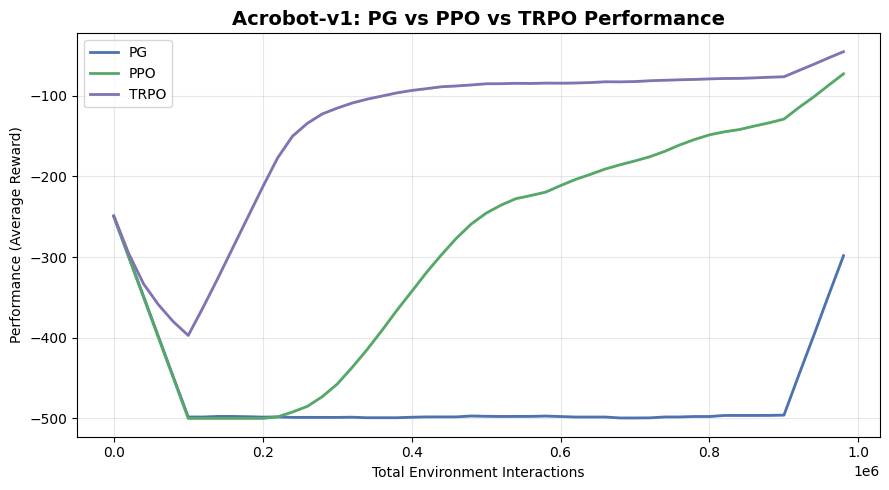

📈 Plotting Ant-v5 ...


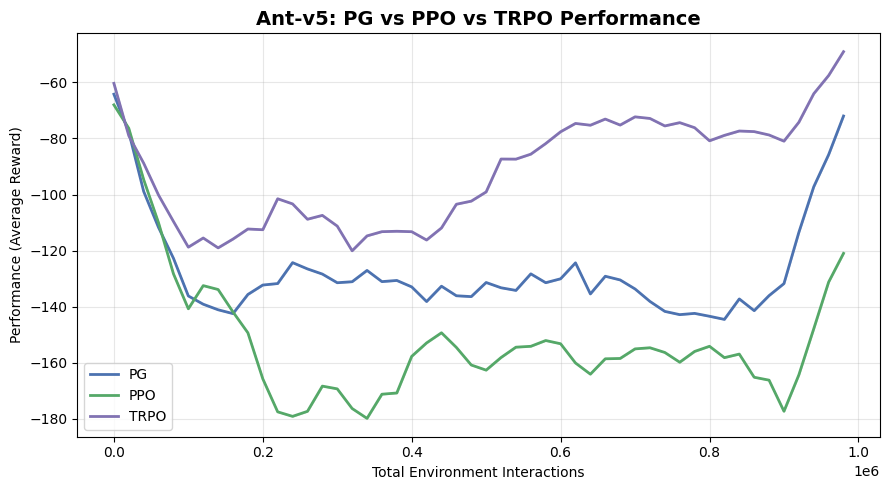

📈 Plotting HalfCheetah-v5 ...


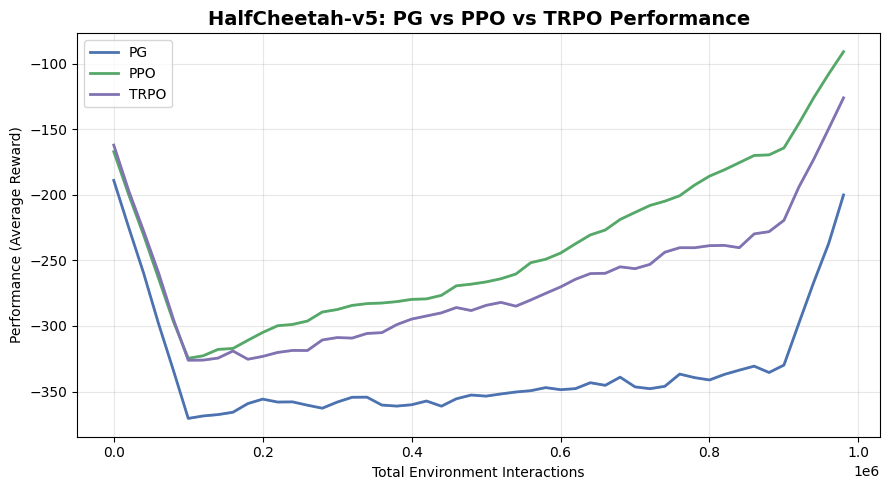

📈 Plotting LunarLander-v3 ...


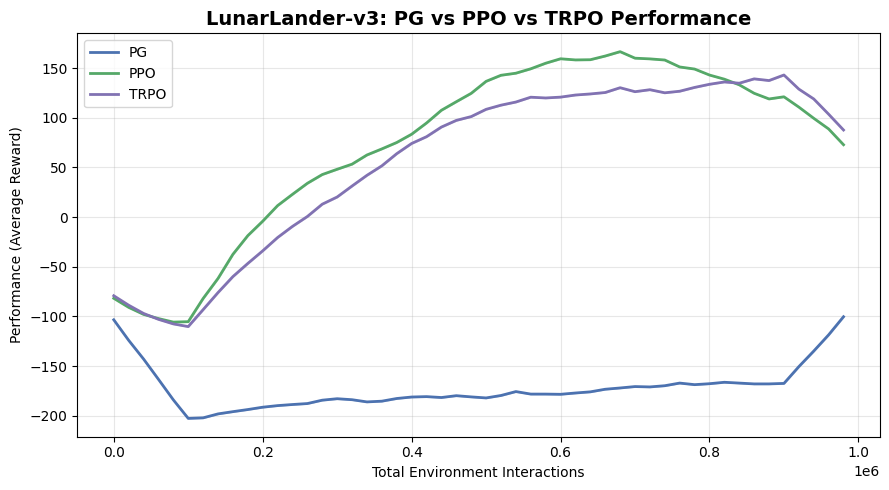

📈 Plotting Reacher-v5 ...


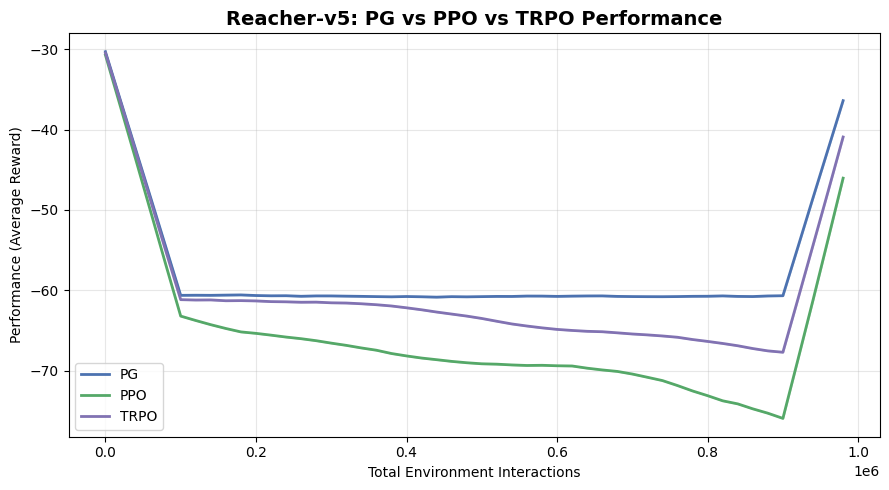

✅ All environment plots saved!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

plt.style.use('seaborn-v0_8-muted')
 
colors = {
    "PG": "#4C72B0",      
    "PPO": "#55A868",     
    "TRPO": "#8172B2"    
}
 
def smooth(y, box_pts=10):
    if len(y) < box_pts:
        return y
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
 
files = sorted(glob.glob("scores_*.npy")) 
envs = sorted(set(["_".join(f.split("_")[1:-1]) for f in files]))
 
for env in envs:
    plt.figure(figsize=(9, 5)) 

    for algo in ["PG", "PPO", "TRPO"]:
        matching_files = [f for f in files if env in f and algo in f]
        if not matching_files:
            continue

        data = [np.load(f) for f in matching_files if os.path.getsize(f) > 0]
        if not data:
            continue

        rewards = np.array([d for d in data if len(d) > 0])
        if len(rewards.shape) == 1:
            rewards = rewards.reshape(1, -1)

        mean = np.mean(rewards, axis=0)
        std = np.std(rewards, axis=0)

        timesteps = np.arange(len(mean)) * 20000  
        smoothed_mean = smooth(mean, box_pts=10)

        plt.plot(timesteps, smoothed_mean, label=algo, color=colors[algo], linewidth=2)
        plt.fill_between(timesteps, smoothed_mean - std, smoothed_mean + std, color=colors[algo], alpha=0.2)

    plt.title(f"{env}: PG vs PPO vs TRPO Performance", fontsize=14, fontweight='bold')
    plt.xlabel("Total Environment Interactions")
    plt.ylabel("Performance (Average Reward)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{env}_comparison.png", dpi=300)
    plt.show()
 
